<h3> h3> This is the Weekly prediction of Google stock you can choose any stock data and change it's symbol in the code below</h3>

Importing libraries -

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from dateutil.parser import parse

Import your own Aplha Vantage API key and the symbol of the stock you want to predict the data of - 

In [36]:
api_key = "AABCA71GGJ5WS2LZ"
symbols = ["GOOGL"]

Initialize empty DataFrames to store data for all stocks

In [37]:
dfs = []

Define the API url for the current stock and make a GET request to retreive the data

In [38]:
for symbol in symbols:
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol={symbol}&apikey={api_key}"
    r = requests.get(url)
    data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Weekly Prices (open, high, low, close) and Volumes', '2. Symbol': 'GOOGL', '3. Last Refreshed': '2023-09-28', '4. Time Zone': 'US/Eastern'}, 'Weekly Time Series': {'2023-09-28': {'1. open': '129.8300', '2. high': '133.3000', '3. low': '127.2200', '4. close': '132.3100', '5. volume': '90739306'}, '2023-09-22': {'1. open': '136.6100', '2. high': '139.1600', '3. low': '129.6000', '4. close': '130.2500', '5. volume': '130043721'}, '2023-09-15': {'1. open': '136.5400', '2. high': '138.6950', '3. low': '134.1500', '4. close': '137.4000', '5. volume': '123588933'}, '2023-09-08': {'1. open': '135.4400', '2. high': '136.6600', '3. low': '132.9500', '4. close': '136.3800', '5. volume': '80516176'}, '2023-09-01': {'1. open': '131.3100', '2. high': '138.0000', '3. low': '130.1400', '4. close': '135.6600', '5. volume': '143532078'}, '2023-08-25': {'1. open': '127.1750', '2. high': '134.2500', '3. low': '126.5600', '4. close': '129.8800', '5. volume': '130399547'}, 

Check if 'Weekly Time Series' available in data 

In [39]:
weekly_data = data['Weekly Time Series']
df = pd.DataFrame.from_dict(weekly_data, orient="index")

Convert data into dataframe and sort dataframe by the date

In [40]:
df.index = [parse(date) for date in df.index]  
df = df.sort_index()

Extract the 'Close' prices

In [41]:
if '4. close' in df:
    close_prices = df['4. close'].astype(float)

Normalize the 'Close' prices

In [42]:
scaler = MinMaxScaler()
close_prices_normalized = scaler.fit_transform(close_prices.values.reshape(-1, 1))

Define sequence length and split data into sequences

In [43]:
sequence_length = 10
sequences = []
next_week_close_prices = []

for i in range(len(close_prices_normalized) - sequence_length):
    sequences.append(close_prices_normalized[i:i + sequence_length])
    next_week_close_prices.append(close_prices_normalized[i + sequence_length])

Convert lists to NumPy arrays

In [44]:
X = np.array(sequences)
y = np.array(next_week_close_prices)

Split the data into training and testing sets

In [45]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Build an LSTM model

In [46]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(units=50, return_sequences=True),
    LSTM(units=50),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

Train the model

In [47]:
model.fit(X_train, y_train, epochs=50, batch_size=16)

Epoch 1/50
50/50 [==============================] - 4s 6ms/step - loss: 0.0069
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 7.2885e-04
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 7.7256e-04
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 8.2427e-04
Epoch 6/50
50/50 [==============================] - 0s 6ms/step - loss: 7.4754e-04
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 6.9119e-04
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 6.9554e-04
Epoch 9/50
50/50 [==============================] - 0s 6ms/step - loss: 6.7683e-04
Epoch 10/50
50/50 [==============================] - 0s 6ms/step - loss: 6.6736e-04
Epoch 11/50
50/50 [==============================] - 0s 6ms/step - loss: 7.5602e-04
Epoch 12/50
50/50 [==============================] - 0s 6ms/step - loss: 6.4738e-04
Epoch 13/

Make predictions

In [48]:
predictions = model.predict(X_test)

7/7 [==============================] - 1s 3ms/step


Inverse transform predictions to original scale

In [49]:
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

Calculate Mean Squared Error (MSE) as an evaluation metric

In [50]:
mse = mean_squared_error(y_test_original, predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 34325.58379906676


Plot actual vs. predicted prices

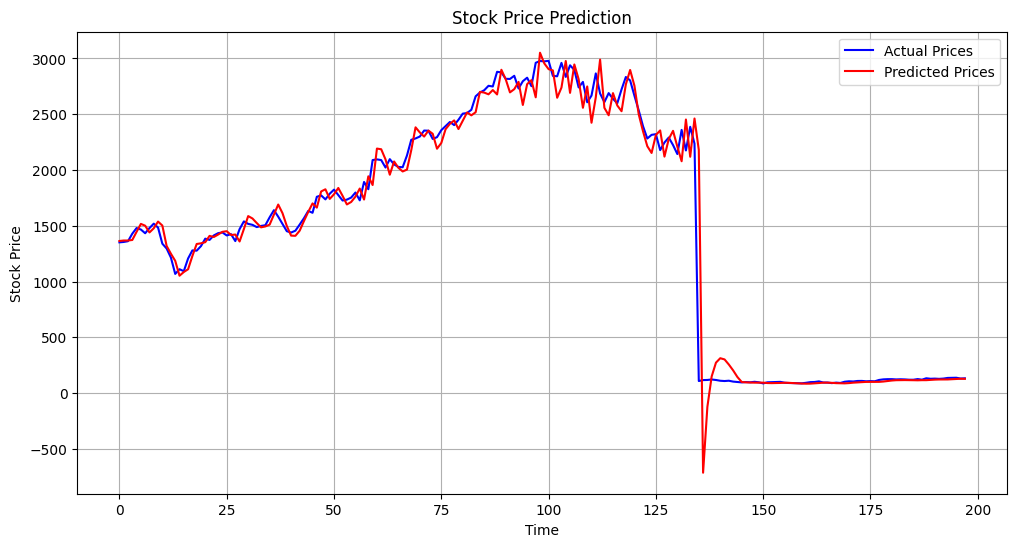

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.show()